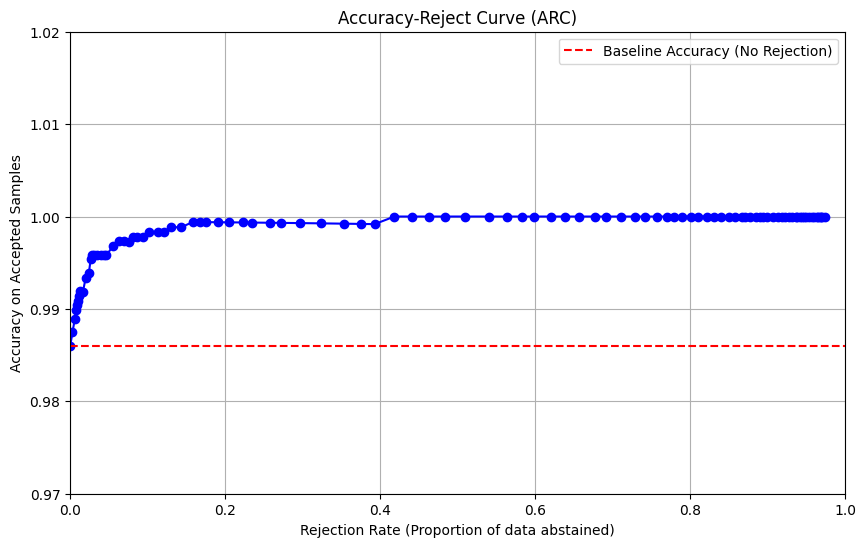

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 1. LOAD REAL DATASET
df = pd.read_csv('data/spam_and_ham_classification.csv')
df['label_enc'] = df['label'].map({'ham': 0, 'spam': 1})

# 2. PREPROCESSING
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text'])
y = df['label_enc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. TRAIN SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Get decision scores
decision_scores = svm_model.decision_function(X_test)

# 4. CALCULATE METRICS FOR ARC CURVE
thresholds = np.linspace(0, 2.5, 100)
rejection_rates = []
accuracies = []

for tau in thresholds:
    # Rejection Logic: Reject if -tau <= score <= tau
    # Equivalently: Keep if |score| > tau
    accepted_indices = np.abs(decision_scores) > tau
    
    # Calculate Rejection Rate
    n_total = len(y_test)
    n_accepted = np.sum(accepted_indices)
    n_rejected = n_total - n_accepted
    rejection_rate = n_rejected / n_total
    
    # Calculate Accuracy on Accepted
    if n_accepted > 0:
        y_true_acc = y_test[accepted_indices]
        y_pred_acc = (decision_scores[accepted_indices] > 0).astype(int) # Standard SVM logic for prediction
        acc = accuracy_score(y_true_acc, y_pred_acc)
    else:
        acc = 1.0 # Default if everything is rejected (edge case) or np.nan
        
    rejection_rates.append(rejection_rate)
    accuracies.append(acc)

# 5. PLOT ARC
plt.figure(figsize=(10, 6))
plt.plot(rejection_rates, accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy-Reject Curve (ARC)')
plt.xlabel('Rejection Rate (Proportion of data abstained)')
plt.ylabel('Accuracy on Accepted Samples')
plt.grid(True)
plt.xlim([0, 1.0])
plt.ylim([0.97, 1.02]) # Zoom in on the top half usually
plt.axhline(y=accuracies[0], color='r', linestyle='--', label='Baseline Accuracy (No Rejection)')
plt.legend()

plt.savefig('arc_curve.png')

In [ ]:
def predict_with_uncertainty(text_input, model, vectorizer, threshold=1.0):
    # 1. Preprocess the single input
    # transform expects a list/iterable, so we wrap text_input in []
    vectorized_input = vectorizer.transform([text_input])
    
    # 2. Get the decision score (Distance to boundary)
    # This returns an array, so we grab the first element [0]
    score = model.decision_function(vectorized_input)[0]
    
    # 3. Apply Rejection Logic
    # If the absolute distance is smaller than your margin, you are unsure.
    if abs(score) <= threshold:
        print(f"Input: '{text_input}'")
        print(f"  -> Prediction: Unsure (Score: {score:.2f} is within margin +/-{threshold})")
        return "Unsure"
        
    # 4. Standard Prediction (if confident)
    elif score > threshold:
        prediction = "SPAM"
    else: # score < -threshold
        prediction = "HAM"
        
    print(f"Input: '{text_input}'")
    print(f"  -> Prediction: {prediction} (Score: {score:.2f})")
    return prediction

# --- Usage Example ---

# Define your "safety margin" (Tau). 
# Based on your graph, a value around 0.5 to 1.0 looks robust.
tau = 0.3

# Test on new phrases
predict_with_uncertainty("", svm_model, vectorizer, threshold=tau)
predict_with_uncertainty("listmaster lists debian org", svm_model, vectorizer, threshold=tau)

# Test on a deliberately ambiguous phrase (likely to trigger 'Unsure')
# Ambiguous because it mixes "urgent" (spammy) with "project" (hammy)
predict_with_uncertainty("Ur 9 ge 10  1040 40 304 9 90 nt  9 project update regarding the offer 1 23  3 45 5 67 7 856 2 3423 23 9", svm_model, vectorizer, threshold=tau)

Input: 'take a look at this one campaign for bvyhprice escapenumber escapenumber escapenumber day target price escapenumber escapenumbermarket hellish this sym is gaining momentum see the news theescapenumber call your brokertake a look at this one campaign for bvyhprice escapenumber escapenumber escapenumber day target price escapenumber escapenumbermarket hellish this sym is gaining momentum see the news theescapenumber call your brokertake a look at this one campaign for bvyhprice escapenumber escapenumber escapenumber day target price escapenumber escapenumbermarket hellish this sym is gaining momentum see the news theescapenumber call your brokertake a look at this one campaign for bvyhprice escapenumber escapenumber escapenumber day target price escapenumber escapenumbermarket hellish this sym is gaining momentum see the news theescapenumber call your brokertake a look at this one campaign for bvyhprice escapenumber escapenumber escapenumber day target price escapenumber escapenu

'HAM'